# Hyperparameter tuning

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

## Presentation

Step 1: random search over a lot of models and parameters

Step 2: bayesian search

Step 3: evaluate best models with cross validation

For the seed, we always take the same seed: 100

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import imageio

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import keras_tuner as kt
import tensorflow_datasets as tfds

from amftrack.ml.width.models import hyper_model_builder_simple, build_model_dense, build_model_conv
from amftrack.util.sys import storage_path
from amftrack.ml.width.data_augmentation import data_augmentation

2022-08-12 14:10:26.926611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 14:10:26.926628: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-12 14:10:46.589491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/kahane/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-12 14:10:46.589512: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 14:10:46.589527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (morricone.ipa.amolf.nl): /proc

### Fetch data

In [6]:
path = os.path.join(storage_path, "train_final")
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [7]:
im = imageio.imread(im_path)
print(im.shape)

(1512, 120)


In [8]:
with open(label_path, 'rb') as f:
    label = np.load(f)
print(label.shape)

(1512,)


In [9]:
label = np.expand_dims(label, axis = 1)

In [10]:
label.shape

(1512, 1)

### Data preparation

In [11]:
seed = 11

In [12]:
np.random.seed(11)

In [13]:
p = np.random.permutation(224)

In [14]:
training = p[:150]
test = p[150:]
print(len(training))
print(len(test))

150
74


In [15]:
train_feature = im[training, :]
train_label = label[training,0]
test_feature = im[test, :]
test_label = label[test, :]

In [16]:
test_feature.shape

(74, 120)

## Visualisation

In [17]:
i = 68

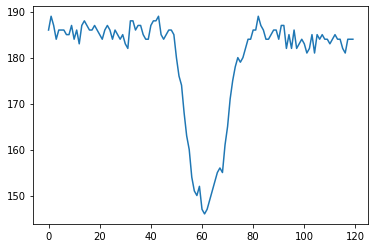

In [18]:
plt.plot(im[i,:])

In [19]:
label[i,:]

array([5.39951104])

In [20]:
label[i,:]

array([5.39951104])

## Random search with dense model

### Training

In [21]:
from amftrack.ml.width.data_augmentation import data_preparation

In [22]:
train_feature.shape

(150, 120)

In [151]:
data_preparation(train_feature).shape

TensorShape([150, 80, 1])

In [13]:
tuner = kt.RandomSearch(
    build_model_dense,
    objective='val_mean_absolute_error',
    max_trials=50,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True
)

In [20]:
tuner.search(data_preparation(train_feature),
             train_label,
             validation_split=0.2,
             epochs=100,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Trial 50 Complete [00h 00m 06s]
val_mean_absolute_error: 0.7195175886154175

Best val_mean_absolute_error So Far: 0.658259391784668
Total elapsed time: 00h 05m 54s
INFO:tensorflow:Oracle triggered exit
2022-06-07 16:18:06,772-[INFO]- tensorflow:1 -> Oracle triggered exit


### Analyse results: run 2

#### Results

In [43]:
best_model = tuner.get_best_models(1)[0]

In [27]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [28]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 reshape (Reshape)           (None, 80)                0         
                                                                 
 rescaling (Rescaling)       (None, 80)                0         
                                                                 
 dense (Dense)               (None, 74)                5994      
                                                                 
 dropout (Dropout)           (None, 74)                0         
                                                                 
 dense_1 (Dense)             (None, 74)                5550      
                                                                 
 dropout_1 (Dropout)         (None, 74)                0     

In [29]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 0.0014215854798312684
dense_blocks: 4
dropout: 0.0
learning_rate: 0.0009024056738718249
Score: 0.658259391784668
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 2.2980497006447554e-05
dense_blocks: 10
dropout: 0.0
learning_rate: 0.002103917275801273
Score: 0.7131851315498352
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 42
regul: 0.0035557261842639634
dense_blocks: 3
dropout: 0.0
learning_rate: 0.0016003804865801434
Score: 0.7195175886154175
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 10
regul: 0.00023822269216557592
dense_blocks: 1
dropout: 0.0
learning_rate: 0.011363871072843399
Score: 0.7515721917152405
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 0.00021301425578360573
dense_blocks: 2
dropout: 0.4
learning_rate: 0.0008633835677522632
Score: 0.771540105342865
Trial summary
Hy

In [30]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_size (Fixed)
{'conditions': [], 'value': 80}
hidden_size (Int)
{'default': 32, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 32, 'sampling': None}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
dense_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [31]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

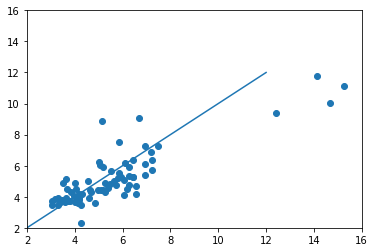

In [33]:
plot_against(best_model, data_preparation(test_feature), test_label)

In [38]:
feature_vector = data_preparation(test_feature)

In [44]:
best_model.evaluate(feature_vector, test_label)

3/3 [==============================] - 0s 1ms/step - loss: 3.1173 - mean_absolute_error: 0.9405


[3.117264986038208, 0.940484344959259]

In [45]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 reshape (Reshape)           (None, 80)                0         
                                                                 
 rescaling (Rescaling)       (None, 80)                0         
                                                                 
 dense (Dense)               (None, 74)                5994      
                                                                 
 dropout (Dropout)           (None, 74)                0         
                                                                 
 dense_1 (Dense)             (None, 74)                5550      
                                                                 
 dropout_1 (Dropout)         (None, 74)                0     

#### Evaluate with random crops

In [143]:
def random_crop(output_size):
    # TODO(FK): add name
    # TODO(FK): handle size
    size = [74, output_size, 1]
    return tf.keras.layers.Lambda(lambda x: tf.image.random_crop(x, size=size))


@tf.function
def center_crop_slice(x, margin):
    return x[..., margin:-margin, :]


def center_crop(input_size=120, output_size=80):
    return tf.keras.layers.Lambda(
        lambda x: center_crop_slice(x, (input_size - output_size) // 2)
    )


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
        # random_invert(p=0.5),  # TODO(FK): keep?
        #random_mirror(p=0.5),
        #random_brightness(10),
    ]
)

In [100]:
from amftrack.ml.width.data_augmentation import *

In [79]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
    ]
)

In [132]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [144]:
feature_vector = data_augmentation(test_feature)

In [145]:
tf.random.set_seed(12)

In [146]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [147]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [148]:
best_model.evaluate(feature_vector, test_label)

3/3 [==============================] - 0s 1ms/step - loss: 5.2993 - mean_absolute_error: 1.2498


[5.299310207366943, 1.2498197555541992]

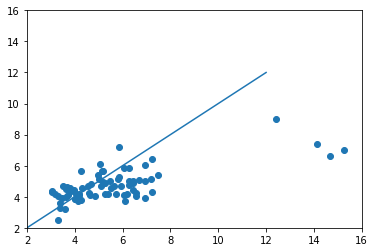

In [149]:
plot_against(best_model, feature_vector, test_label)

### Analyse results: run 1

In [37]:
best_model = tuner.get_best_models(1)[0]

In [38]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [39]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 reshape (Reshape)           (None, 120)               0         
                                                                 
 rescaling (Rescaling)       (None, 120)               0         
                                                                 
 dense (Dense)               (None, 74)                8954      
                                                                 
 dropout (Dropout)           (None, 74)                0         
                                                                 
 dense_1 (Dense)             (None, 74)                5550      
                                                                 
 dropout_1 (Dropout)         (None, 74)                0     

In [40]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 0.0014215854798312684
dense_blocks: 4
dropout: 0.0
learning_rate: 0.0009024056738718249
Score: 0.6060740947723389
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 2.2980497006447554e-05
dense_blocks: 10
dropout: 0.0
learning_rate: 0.002103917275801273
Score: 0.6174165606498718
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 42
regul: 0.0035557261842639634
dense_blocks: 3
dropout: 0.0
learning_rate: 0.0016003804865801434
Score: 0.6346872448921204
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 1.1197291634395498e-05
dense_blocks: 2
dropout: 0.30000000000000004
learning_rate: 0.0013053937581869813
Score: 0.6696577668190002
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 0.0005968120420262622
dense_blocks: 1
dropout: 0.5
learning_rate: 0.06229989301913533
Score: 0.769802153110

In [41]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_size (Fixed)
{'conditions': [], 'value': 120}
hidden_size (Int)
{'default': 32, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 32, 'sampling': None}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
dense_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [46]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

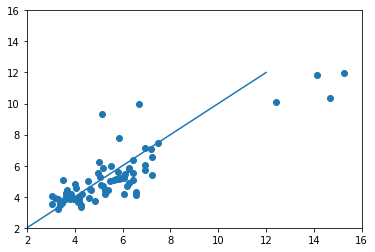

In [47]:
plot_against(best_model, test_feature, test_label)

In [50]:
best_model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 1ms/step - loss: 3.1182 - mean_absolute_error: 0.8862


[3.118171453475952, 0.8862246870994568]

In [51]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 reshape (Reshape)           (None, 120)               0         
                                                                 
 rescaling (Rescaling)       (None, 120)               0         
                                                                 
 dense (Dense)               (None, 74)                8954      
                                                                 
 dropout (Dropout)           (None, 74)                0         
                                                                 
 dense_1 (Dense)             (None, 74)                5550      
                                                                 
 dropout_1 (Dropout)         (None, 74)                0     

In [23]:
tuner.get_best_models(5)

## Random search with conv model

### Training

In [23]:
tuner = kt.RandomSearch(
    build_model_conv,
    objective='val_mean_absolute_error',
    max_trials=50,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True
)

In [25]:
tuner.search(data_preparation(im),
             label,
             validation_split=0.2,
             epochs=200,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights = True)])

Trial 50 Complete [00h 02m 13s]
val_mean_absolute_error: 0.8619729280471802

Best val_mean_absolute_error So Far: 0.702015221118927
Total elapsed time: 01h 30m 12s
INFO:tensorflow:Oracle triggered exit
2022-08-12 15:44:42,115-[INFO]- tensorflow:1 -> Oracle triggered exit


### Analyse results

In [27]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
regul: 0.0002707623734125964
batch_normalization: True
conv_blocks: 3
filters_0: 224
kernel_size0: 19
filters_1: 160
kernel_size1: 20
pooling_1: avg
hidden_size: 10
dense_blocks: 3
dropout: 0.1
learning_rate: 0.020272548846591663
pooling_0: avg
filters_2: 256
kernel_size2: 17
pooling_2: none
Score: 0.702015221118927
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00010991863288278036
batch_normalization: False
conv_blocks: 2
filters_0: 64
kernel_size0: 14
filters_1: 160
kernel_size1: 18
pooling_1: avg
hidden_size: 42
dense_blocks: 3
dropout: 0.5
learning_rate: 0.00638224910178181
pooling_0: max
filters_2: 192
kernel_size2: 15
pooling_2: max
Score: 0.704502284526825
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00032199506051567314
batch_normalization: True
conv_blocks: 2
filters_0: 64
kernel_size0: 13
filters_1: 160
kernel_size1: 5
pooling_1: avg
hidden_siz

In [28]:
best_model = tuner.get_best_models(2)[1]

2022-08-12 15:46:06,331-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-12 15:46:06,334-[WARNI

In [29]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [30]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 rescaling (Rescaling)       (None, 80, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 71, 64)            704       
                                                                 
 re_lu (ReLU)                (None, 71, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 160)           102560    
                                                                 
 re_lu_1 (ReLU)              (None, 62, 160)           0         
                                                                 
 average_pooling1d (AverageP  (None, 31, 160)          0     

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
input_size (Fixed)
{'conditions': [], 'value': 80}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
conv_blocks (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
pooling_1 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max', 'none'], 'ordered': False}
hidden_size (Int)
{'

In [32]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

In [33]:
test_feature

Array([[179, 178, 179, ..., 166, 169, 169],
       [188, 185, 185, ..., 191, 193, 192],
       [184, 186, 184, ..., 183, 182, 180],
       ...,
       [191, 189, 191, ..., 195, 193, 195],
       [187, 187, 188, ..., 189, 190, 190],
       [187, 185, 186, ..., 163, 162, 166]], dtype=uint8)

In [56]:
path = os.path.join(storage_path, "test_final")
im_path_test = os.path.join(path, "slices.png")
label_path_test = os.path.join(path, "labels.npy")

In [57]:
im_test = imageio.imread(im_path_test)
print(im_test.shape)

(810, 120)


In [61]:
with open(label_path, 'rb') as f:
    label_test = np.load(f)
print(label_test.shape)

(810,)


In [62]:
label_test = np.expand_dims(label_test, axis = 1)

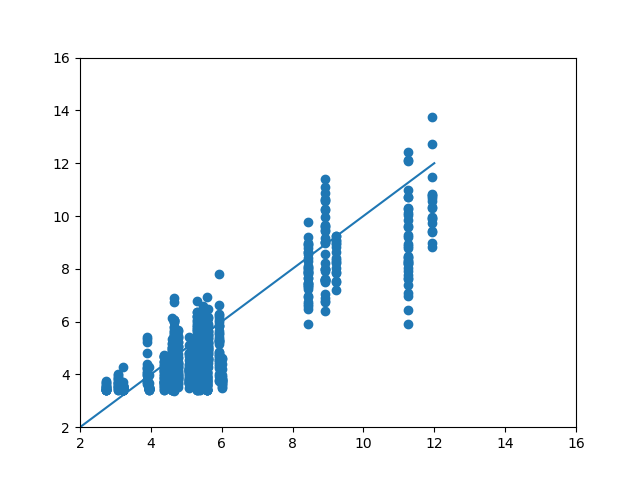

In [64]:
%matplotlib widget
plot_against(best_model, data_preparation(im_test), label_test)

In [66]:
save_path = os.path.join(storage_path, "models", "model_vendredi")
best_model.save(save_path)

2022-08-12 16:34:00.585513: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets
2022-08-12 16:34:02,605-[INFO]- tensorflow:779 -> Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets


In [38]:
best_model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 6ms/step - loss: 2.2786 - mean_absolute_error: 1.0133


[2.278571844100952, 1.0132561922073364]

In [39]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 111, 160)          1760      
                                                                 
 re_lu (ReLU)                (None, 111, 160)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 102, 128)          204928    
                                                                 
 re_lu_1 (ReLU)              (None, 102, 128)          0         
                                                                 
 average_pooling1d (AverageP  (None, 51, 128)          0     

In [40]:
tuner.get_best_models(5)

2022-06-07 15:53:58,773-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-06-07 15:53:58,774-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-06-07 15:53:58,775-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-06-07 15:53:58,777-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-06-07 15:53:58,778-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-06-07 15:53:58,779-[WARNI

### Evaluate with data augmentation

In [49]:
from amftrack.ml.width.data_augmentation import *

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(120),
        # random_invert(p=0.5),  # TODO(FK): keep?
        random_mirror(p=0.5),
        random_brightness(20),
    ]
)

In [50]:
data_preparation

In [42]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [44]:
test_label.shape

(74, 1)

In [45]:
test_feature_ = data_augmentation(test_feature)

TensorShape([1, 80, 1])

In [ ]:
best_model.evaluate(test_feature, test_label)

In [41]:
data_augmentation